Environment Setup

Use magnitudes and phases resulting from DFT as input.
Input size now x2.
phase needs to be unwrapped
try conv layer hybrid

In [4]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import librosa
import itertools
import matplotlib.pyplot as plt
import random
from torch.utils.data import DataLoader, Dataset
import models
from utils import *
import scipy.signal
import importlib
importlib.reload(models)
from models import *
from torch.utils.tensorboard import SummaryWriter


# hyperparameters
samplerate = 16000
num_epochs = 300
hidden_size = 256
second_hidden_size = 256
third_hidden_size = 256
learning_rate = 0.001
# the f0 range is from 50 to 500 Hz, it should cover the longest f0 in the dataset, so 50Hz=0.02s
segment_length_in_seconds = 0.02
# noise level
segment_length_in_samples = int(segment_length_in_seconds * samplerate)
batch_size = 1
representation_type = 'Mel'

# Parameters for the band-pass filter
lowcut = 50.0  # Low frequency cut-off in Hz
highcut = 3000.0  # High frequency cut-off in Hz

# STFT parameters
n_fft = 2048
hop_length = 512
window = 'hann'
num_frames = 100

Data set building

In [7]:
# load all wav files in audio
audio = []
for root, dirs, files in os.walk('audio'):
    for file in files:
        if file.endswith('.wav'):
            audio.append(os.path.join(root, file))
raw_wav = []

# the audio is 2 channel audio, concatenate them along the time axis
for i in range(len(audio)):
    wav, _ = librosa.load(audio[i], sr=samplerate, mono=False)
    raw_wav = np.concatenate((raw_wav, wav), axis=-1) if i != 0 else wav

audio_wav = raw_wav[0]
egg_wav = raw_wav[1]

# Compute the STFT
stft_result_audio = librosa.stft(audio_wav, n_fft=n_fft, hop_length=hop_length, window=window)
stft_result_egg = librosa.stft(egg_wav, n_fft=n_fft, hop_length=hop_length, window=window)


# Extract magnitude and phase
magnitude_audio = np.real(stft_result_audio)
phase_audio = np.imag(stft_result_audio)

magnitude_egg = np.real(stft_result_egg)
phase_egg = np.imag(stft_result_egg)

# add magnitude and phase into one feature vector. the first half of n_fft/2+1 is audio, the second half is egg.
complex_audio = np.concatenate((magnitude_audio, phase_audio), axis=0)
complex_egg = np.concatenate((magnitude_egg, phase_egg), axis=0)

def reshape_mel_spectrogram(mel_input, num_frames):
    """
    Reshape a Mel spectrogram from (n_mels, total_samples) to (num_samples, num_frames, n_mels).

    Args:
        mel_input (numpy.ndarray): The Mel spectrogram with shape (n_mels, total_samples).
        num_frames (int): The desired number of frames (time steps) for each sample.

    Returns:
        numpy.ndarray: The reshaped Mel spectrogram with shape (num_samples, num_frames, n_mels).
    """
    n_mels, total_samples = mel_input.shape
    # Ensure that the total number of samples is divisible by the number of frames, if not, delete the last frame
    mel_input = mel_input[:, :-(total_samples % num_frames)]

    # Calculate the number of samples we'll end up with after the reshape
    num_samples = total_samples // num_frames

    # Reshape the Mel spectrogram
    reshaped_mel_input = mel_input.T.reshape(num_samples, num_frames, n_mels)

    return reshaped_mel_input
    

reshaped_mel_input = reshape_mel_spectrogram(complex_audio, num_frames)
reshaped_mel_target = reshape_mel_spectrogram(complex_egg, num_frames)

class VoiceDataset(Dataset):
    def __init__(self, input_mel_specs, target_mel_specs):
        """
        Initializes the dataset with input and target Mel spectrograms.

        Args:
        input_mel_specs (numpy.ndarray): A 3D numpy array of shape (num_samples, num_frames, n_mels)
                                         containing the Mel spectrogram for the input audio.
        target_mel_specs (numpy.ndarray): A 3D numpy array of shape (num_samples, num_frames, n_mels)
                                          containing the Mel spectrogram for the target audio.
        """
        assert input_mel_specs.shape == target_mel_specs.shape, "Input and target spectrograms must have the same shape"
        
        self.input_mel_specs = input_mel_specs
        self.target_mel_specs = target_mel_specs

    def __len__(self):
        """Returns the number of samples in the dataset."""
        return self.input_mel_specs.shape[0]

    def __getitem__(self, idx):
        """
        Returns the input and target Mel spectrogram for a given index.

        Args:
        idx (int): The index of the sample.

        Returns:
        Tuple[torch.Tensor, torch.Tensor]: The input and target Mel spectrograms as PyTorch tensors.
        """
        input_spec = torch.tensor(self.input_mel_specs[idx], dtype=torch.float32)
        target_spec = torch.tensor(self.target_mel_specs[idx], dtype=torch.float32)
        
        return input_spec, target_spec

# Assuming input_mel_specs and target_mel_specs are your datasets
dataset = VoiceDataset(reshaped_mel_input, reshaped_mel_target)

# split the dataset into training and validation sets and test sets
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

# shuffle the dataset
torch.manual_seed(0)
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



Epoch: 1/300, Training Loss: 0.3335, Validation Loss: 0.3333, LR: 0.001
Epoch: 2/300, Training Loss: 0.3328, Validation Loss: 0.3334, LR: 0.001
Epoch: 3/300, Training Loss: 0.3307, Validation Loss: 0.3346, LR: 0.001
Epoch: 4/300, Training Loss: 0.3276, Validation Loss: 0.3365, LR: 0.001
Epoch: 5/300, Training Loss: 0.3246, Validation Loss: 0.3387, LR: 0.001
Epoch: 6/300, Training Loss: 0.3221, Validation Loss: 0.3409, LR: 0.001
Epoch: 7/300, Training Loss: 0.3199, Validation Loss: 0.3428, LR: 0.0001
Epoch: 8/300, Training Loss: 0.3152, Validation Loss: 0.3464, LR: 0.0001
Epoch: 9/300, Training Loss: 0.3140, Validation Loss: 0.3475, LR: 0.0001
Epoch: 10/300, Training Loss: 0.3132, Validation Loss: 0.3482, LR: 0.0001
Epoch: 11/300, Training Loss: 0.3127, Validation Loss: 0.3488, LR: 0.0001
Early stopping triggered


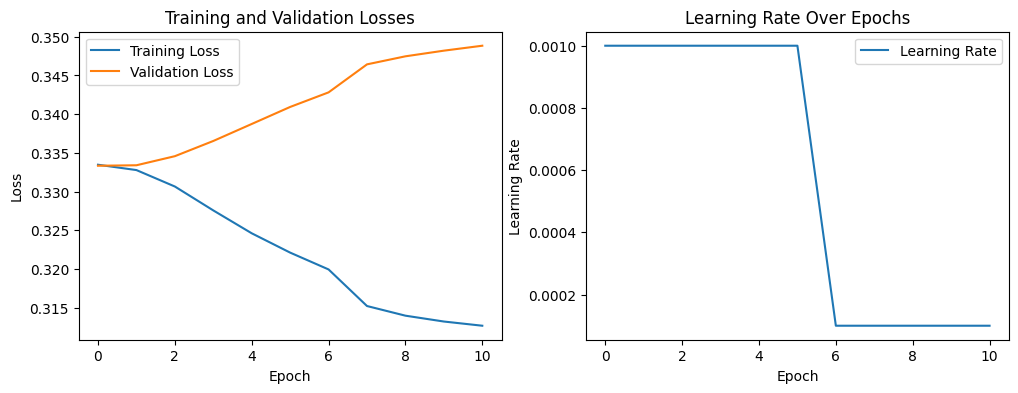

In [8]:
# n_mels = n_fft//2 +1 
model = LSTMmodel(n_mels=3075, hidden_size=hidden_size, num_layers=2)
log_name = f'{type(model).__name__}_{representation_type}_bs{batch_size}'
writer = SummaryWriter('runs/experiment_name')

sample_input = torch.randn(batch_size, segment_length_in_samples)
# writer.add_graph(model, sample_input)

tensorboard_log_config(writer, model, representation_type, samplerate, segment_length_in_seconds, batch_size)
trained_model = train_model(writer, model, train_loader, val_loader, num_epochs, learning_rate)
writer.close()


In [ ]:
model.eval()  # Ensure the model is in evaluation mode

predictions = []  # To store model predictions
actuals = []  # To store actual target values for comparison
audios = []  # To store audio samples

with torch.no_grad():  # Disable gradient calculation for efficiency
    for inputs, targets in test_loader:
        # Move data to the appropriate device (e.g., GPU if available)
        inputs = inputs.to(next(model.parameters()).device)
        
        # Compute model output
        output = model(inputs)
        
        # Store predictions and actuals and inputs
        audios.append(inputs.cpu().numpy())
        predictions.append(output.cpu().numpy())  # Move prediction back to CPU and convert to numpy
        actuals.append(targets.cpu().numpy())  # Same for actual targets

fig, axs = plt.subplots(3, 1, figsize=(20, 10))

# Plot the input waveform
axs[0].imshow(audios[10].T, aspect='auto', origin='lower')
axs[0].set_title('Input audio Mel Spectrogram')

# Plot actual Mel spectrogram
axs[1].imshow(actuals[10].T, aspect='auto', origin='lower')
axs[1].set_title('Actual EGG Mel Spectrogram')

# Plot predicted Mel spectrogram
axs[2].imshow(predictions[10].T, aspect='auto', origin='lower')
axs[2].set_title('Predicted EGG Mel Spectrogram')

plt.show()

In [ ]:
# convert the mel spectrogram back to wav for target and output
mel_audio_test = audios[0].T
mel_output_test = predictions[0].T
mel_target_test = actuals[0].T

# return the Mel spectrogram back to its original 2D shape
mel_audio_test = mel_audio_test.reshape(mel_audio_test.shape[0], mel_audio_test.shape[1])
mel_output_test = mel_output_test.reshape(mel_output_test.shape[0], mel_output_test.shape[1])
mel_target_test = mel_target_test.reshape(mel_target_test.shape[0], mel_target_test.shape[1])

# convert the mel spectrogram back to wav
input_wav_test = librosa.feature.inverse.mel_to_audio(mel_audio_test, sr=samplerate, n_fft=1024, hop_length=256, win_length=None)
output_wav_test = librosa.feature.inverse.mel_to_audio(mel_output_test, sr=samplerate, n_fft=1024, hop_length=256, win_length=None)
target_wav_test = librosa.feature.inverse.mel_to_audio(mel_target_test, sr=samplerate, n_fft=1024, hop_length=256, win_length=None)

# plot the input, the target, the prediction
plt.figure()
plt.subplot(3, 1, 1)
plt.plot(input_wav_test)
plt.subplot(3, 1, 2)
plt.plot(output_wav_test)
plt.subplot(3, 1, 3)
plt.plot(target_wav_test)
plt.show()

In [ ]:
# # save the output wav
# librosa.output.write_wav('output.wav', output_wav_test, samplerate)
# librosa.output.write_wav('target.wav', target_wav_test, samplerate)
# librosa.output.write_wav('input.wav', input_wav_test, samplerate)

# save the model
torch.save(model.state_dict(), 'model.pth')

